In [1]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import tqdm as tqdm

from multirtd.utils import rand_in_bounds, rot_mat_2D, plot_environment, plot_trajectory, check_obs_collision
from multirtd.dynamics.dubins_model import dubins_traj, dubins_traj_fast
import multirtd.params as params

%load_ext autoreload
%autoreload 2

cvxpy 

In [ ]:
import cvxpy as cp

# Problem data.
goal = np.array([10, 10])


# Construct the problem.
u = cp.Variable(2)
x = cp.Variable(2)
objective = cp.Minimize(cp.norm(x - goal))
constraints = [0 <= u, u <= 1]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print(x.value)
# The optimal Lagrange multiplier for a constraint is stored in
# `constraint.dual_value`.
print(constraints[0].dual_value)

Smooth optimization

In [ ]:
def dx(v, w, t, eps=1e-15):
    return v * np.sin((w + eps) * t) / (w + eps)

def dy(v, w, t, eps=1e-15):
    return v * (1 - np.cos((w + eps) * t)) / (w + eps)

In [ ]:
def cost(u):
    tf = 3.0
    goal = np.array([5.0, 1.0])
    
    goal_cost = np.linalg.norm(np.array([dx(u[0], u[1], tf), dy(u[0], u[1], tf)]) - goal)

    obs_cost = 0.0

    return goal_cost + obs_cost

In [ ]:
start_time = time.time()
#u0 = rand_in_bounds([0, params.V_MAX, -params.W_MAX, params.W_MAX], 1)[0]
u0 = np.array([0, 0])
cons = LinearConstraint(A=np.array([[]]), )
res = minimize(cost, u0, method='SLSQP', bounds=[(0, params.V_MAX), (-params.W_MAX, params.W_MAX)],
               constraints=[cons],
               options={'disp': True,
                        'ftol': 1e-6})
print("Time elapsed: {:.3f} s".format(time.time() - start_time))
print(res.x)

Collision to traj parameter mapping

In [ ]:
from multirtd.reachability.zonotope import Zonotope

obstacles = [(np.array([0.25, 0.2]), 0.1)]
x0 = np.array([0, 0, 0])
goal = np.array([2.0, 0.0])

fig, ax = plt.subplots(figsize=(12,6))
plot_environment(ax, None, None, x0, goal)

z_obs = Zonotope(np.array([0.25, 0.2])[:,None], np.array([[0.1, 0], [0, 0.1]]))
z_obs.plot(ax, color='r')

plt.show()

In [ ]:
def check_zono_collision(traj, z):
    """Check if the trajectory collides with any obstacles."""
    for i in range(traj.shape[0]):
        if z.contains(traj[i,:2][:,None]):
            return True
    return False

In [ ]:
w_samples = np.linspace(-params.W_MAX, params.W_MAX, 100)
v_samples = np.linspace(0, params.V_MAX, 100)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
trajs = []
for v in v_samples:
    for w in w_samples:
        traj = dubins_traj_fast(x0, np.array([v, w]), params.TRAJ_IDX_LEN, params.DT)
        trajs.append(traj)
        #if check_obs_collision(traj[:,:2], obstacles[0], 0):
        if not check_zono_collision(traj, z_obs):
            ax.scatter(v, w, c='b')
        else:
            ax.scatter(v, w, c='r')
plt.show()

In [ ]:
# Halfspace approximation


In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

for traj in trajs:
    plot_trajectory(ax, traj, c='b', alpha=0.2)

plot_environment(ax, None, None, x0, goal)
z_obs.plot(ax, color='r')

plt.show()

In [2]:
dt = 0.1
T = 3.0  # 30 steps
N = 30
init_pose = np.zeros(3)
goal = np.array([2, 0.1])

start_time = time.time()
N_trials = 10000
for i in range(N_trials):
    dubins_traj(init_pose, np.random.rand(2), N, dt)
print("Avg time: {:.3f} s".format((time.time() - start_time)/N_trials))
print("Total time: {:.3f} s".format(time.time() - start_time))

# TODO: add braking maneuver

Avg time: 0.000 s
Total time: 0.017 s


In [3]:
start_time = time.time()
N_trials = 10000
for i in range(N_trials):
    dubins_traj_fast(init_pose, np.random.rand(2), N, dt)
print("Avg time: {:.3f} s".format((time.time() - start_time)/N_trials))
print("Total time: {:.3f} s".format(time.time() - start_time))

Avg time: 0.000 s
Total time: 0.496 s


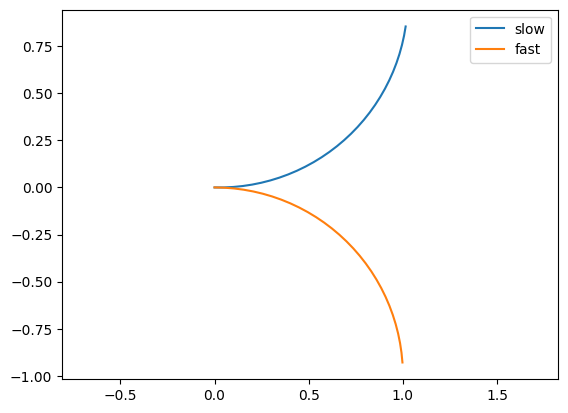

In [4]:
v, w = np.random.rand(2)

In [ ]:
start_time = time.time()
N_trials = 10000
for i in range(N_trials):
    v, w = np.random.rand(2)
    x = [dx(v, w, t) for t in np.linspace(0, T, N)]
    y = [dy(v, w, t) for t in np.linspace(0, T, N)]
print("Avg time: {:.3f} s".format((time.time() - start_time)/N_trials))
print("Total time: {:.3f} s".format(time.time() - start_time))

In [ ]:
from multirtd.dynamics.dubins_model import dubins 

start_time = time.time()
N_trials = 10000
for i in range(N_trials):
    dubins(*np.hstack((init_pose, np.random.rand(2))))
print("Avg time: {:.3f} s".format((time.time() - start_time)/N_trials))
print("Total time: {:.3f} s".format(time.time() - start_time))

In [ ]:
init_pose = np.array([0.0, 0.0, 0.0])
u = np.array([0.5, 0.2])
traj = dubins_traj(init_pose, u, N, dt)
traj_fast = dubins_traj_fast(init_pose, u, N, dt)

plt.figure()
plt.plot(traj[:,0], traj[:,1], label="slow")
plt.plot(traj_fast[:,0], traj_fast[:,1], label="fast")
plt.legend()
plt.axis("equal")
plt.show()

Random uniform sampling

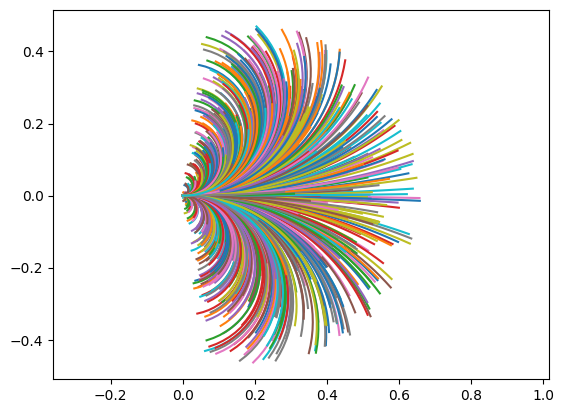

In [5]:
u_samples = rand_in_bounds([0, params.V_MAX, -params.W_MAX, params.W_MAX], params.N_PLAN_MAX)
traj_samples = np.zeros((params.N_PLAN_MAX, params.TRAJ_IDX_LEN, 3))

for i, u in enumerate(u_samples):
    traj_samples[i,:,:] = dubins_traj(init_pose, u, params.TRAJ_IDX_LEN, params.DT)

plt.figure()
for i in range(params.N_PLAN_MAX):
    plt.plot(traj_samples[i,:,0], traj_samples[i,:,1])
plt.axis("equal")
plt.show()

In [ ]:
traj_samples_rotated = traj_samples
theta = np.pi/4
traj_samples_rotated[:,:,0:2] = traj_samples_rotated[:,:,0:2] @ rot_mat_2D(theta)

In [ ]:
plt.figure()
for i in range(params.N_PLAN_MAX):
    plt.plot(traj_samples_rotated[i,:,0], traj_samples_rotated[i,:,1])
plt.axis("equal")
plt.show()

Uniform sampling

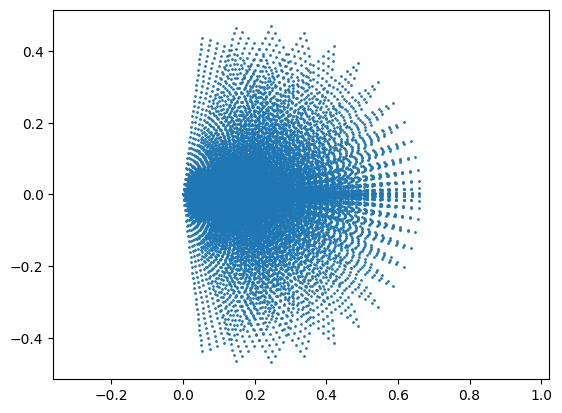

In [6]:
N_unif = 31

v_samples = np.linspace(0, params.V_MAX, N_unif)
w_samples = np.linspace(-np.sqrt(params.W_MAX), np.sqrt(params.W_MAX), N_unif)
w_samples = np.sign(w_samples) * w_samples**2 
# V, W = np.meshgrid(v_samples, w_samples)
# V = V.flatten()
# W = W.flatten()
#u_samples = np.vstack((V, W)).T
#traj_samples = np.zeros((31**2, params.TRAJ_IDX_LEN, 3))
traj_samples = np.zeros((N_unif, N_unif, params.TRAJ_IDX_LEN, 3))
#traj_samples = {}

#for i, u in enumerate(u_samples):
    #traj_samples[i,:,:] = dubins_traj(init_pose, u, params.TRAJ_IDX_LEN, params.DT)
    #traj_samples[u] = dubins_traj(init_pose, u, params.TRAJ_IDX_LEN, params.DT)

for i, v in enumerate(v_samples):
    for j, w in enumerate(w_samples):
        traj_samples[i,j,:,:] = dubins_traj(init_pose, [v, w], params.TRAJ_IDX_LEN, params.DT)

plt.figure()
# for i in range(0, params.TRAJ_IDX_LEN, 10):
#     plt.scatter(traj_samples[:,i,0], traj_samples[:,i,1], s=1)
plt.scatter(traj_samples[:,:,:,0], traj_samples[:,:,:,1], s=1)
# for u, traj in traj_samples:
#     plt.scatter(traj[:,0], traj[:,1], s=1)
plt.axis("equal")
plt.show()

FRS(v, w, t, x) 
FRS(v, w, t, [x, y, theta]) 

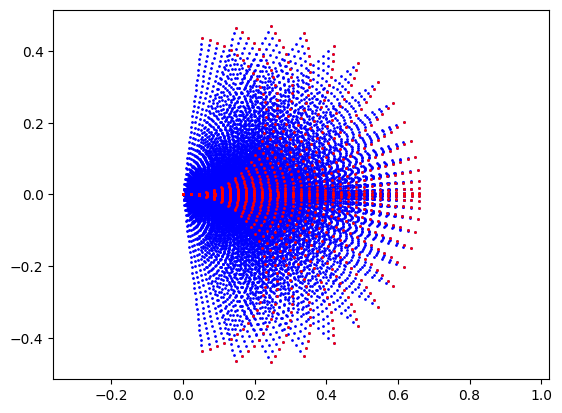

In [7]:
# Slice along v
plt.figure()
plt.scatter(traj_samples[:,:,:,0], traj_samples[:,:,:,1], color='b', s=1)
plt.scatter(traj_samples[-1,:,:,0], traj_samples[-1,:,:,1], color='r', s=1)
plt.axis("equal")
plt.show()

Gaussian sampling

In [ ]:
# v uniform, w gaussian (centered around 0)
#v_samples = np.random.uniform(0, params.V_MAX, 1000)
v_samples = np.ones(1000) * params.V_MAX
w_samples = np.random.normal(0, params.W_MAX/3, 1000)
u_samples = np.vstack((v_samples, w_samples)).T

traj_samples = np.zeros((1000, params.TRAJ_IDX_LEN, 3))

for i, u in enumerate(u_samples):
    traj_samples[i,:,:] = dubins_traj(init_pose, u, params.TRAJ_IDX_LEN, params.DT)

plt.figure()
for i in range(1000):
    plt.plot(traj_samples[i,:,0], traj_samples[i,:,1])
plt.axis("equal")
plt.show()

In [ ]:
u_samples.shape

In [ ]:
# Trajectory parameter space
v_max = 0.22  # [m/s]
w_max = 1.0  # [rad/s]

# Obstacles
obs = [(np.array([0.5, 0.1]), 0.2),
       (np.array([0.4, 0.2]), 0.2)]

# Plot
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 0.5)
# Plot obstacles and start and goal
for obs_c, obs_r in obs:
    ax.add_artist(plt.Circle(obs_c, obs_r, color='r'))
ax.plot(init_pose[0], init_pose[1], 'bo')
ax.plot(goal[0], goal[1], 'go')


### Sampled-based

In [ ]:
def check_collisions(traj, obs):
    """Check if the trajectory collides with any obstacles."""
    for obs_c, obs_r in obs:
        dist = np.linalg.norm(traj[:,:-1] - obs_c, axis=1)
        if np.any(dist < obs_r):
            return True
    return False

In [ ]:
# Sample-based

start_time = time.time()
n_samples = 1000
u_samples = rand_in_bounds([-v_max, v_max, -w_max, w_max], n_samples)
endpoints = np.zeros((n_samples, 2))
for i, u in enumerate(u_samples):
    U = np.tile(u, (N, 1))
    traj = dubins_traj(init_pose, U, dt)
    endpoints[i] = traj[-1,:-1]

dists = np.linalg.norm(endpoints - goal, axis=1)
sort_idxs = np.argsort(dists)
u_samples_sorted = u_samples[sort_idxs]

# Check collisions
for u in u_samples_sorted:
    U = np.tile(u, (N, 1))
    traj = dubins_traj(init_pose, U, dt)
    if check_collisions(traj, obs):
        continue
    else:
        print("found plan ", u)
        break
print("Time elapsed: {:.3f} s".format(time.time() - start_time))

In [ ]:
traj = dubins_traj(init_pose, np.tile(u, (N, 1)), dt)
print(traj)
print(np.linalg.norm(traj[-1,:-1] - goal))

In [ ]:
# Plot trajectory
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 0.5)
# Plot obstacles and start and goal
for obs_c, obs_r in obs:
    ax.add_artist(plt.Circle(obs_c, obs_r, color='r'))
ax.plot(init_pose[0], init_pose[1], 'bo')
ax.plot(goal[0], goal[1], 'go')
ax.plot(traj[:,0], traj[:,1], 'b-')

### Scipy optimize

In [ ]:
# Optimization-based
def cost(u):
    traj = dubins_traj(init_pose, u, N, params.DT)
    dist = np.linalg.norm(traj[-1,:-1] - goal)
    return dist

def constraint(u):
    U = np.tile(u, (N, 1))
    traj = dubins_traj(init_pose, U, dt)
    dist = np.linalg.norm(traj[:,:-1] - obs_c, axis=1)
    return dist

def constraint(u):
    U = np.tile(u, (N, 1))
    traj = dubins_traj(init_pose, U, dt)
    dists = []
    for obs_c, obs_r in obs:
        dist = np.linalg.norm(traj[:,:-1] - obs_c, axis=1) - obs_r
        dists.append(dist)
    return np.hstack(dists)

In [ ]:
start_time = time.time()
cons = NonlinearConstraint(constraint, 0, np.inf)
u0 = rand_in_bounds([-v_max, v_max, -w_max, w_max], 1)[0]
res = minimize(cost, u0, method='SLSQP', bounds=[(-v_max, v_max), (-w_max, w_max)], constraints=cons, 
               options={'disp': True,
                        'ftol': 1e-6})
print("Time elapsed: {:.3f} s".format(time.time() - start_time))
print(res.x)

In [ ]:
# Plot cost contours
n = 100
v = np.linspace(0, params.V_MAX, n)
w = np.linspace(-(params.W_MAX), params.W_MAX, n)
V, W = np.meshgrid(v, w)
C = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        C[i,j] = cost(np.array([V[i,j], W[i,j]]))

In [ ]:
fig = plt.figure(figsize=(12,10))
#ax.set_aspect('equal')
plt.contourf(V, W, C, 20)
plt.colorbar()

In [ ]:
traj = dubins_traj(init_pose, np.tile(res.x, (N, 1)), dt)
print(traj)
print(np.linalg.norm(traj[-1,:-1] - goal))

In [ ]:
# Plot trajectory
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-0.5, 0.5)
# Plot obstacle and start and goal
for obs_c, obs_r in obs:
    ax.add_artist(plt.Circle(obs_c, obs_r, color='r'))
ax.plot(init_pose[0], init_pose[1], 'bo')
ax.plot(goal[0], goal[1], 'go')
ax.plot(traj[:,0], traj[:,1], 'b-')

### Symbolic model

In [ ]:
from sympy import symbols, lambdify, Array, sin, cos, diff

v, w = symbols('v w')

dt = 0.1
N = 10
x0 = Array([0, 0, 0])
expr = x0
for i in range(N):
    expr = expr + dt * Array([v*cos(expr[2]), v*sin(expr[2]), w])

g = lambdify([v, w], expr)

In [ ]:
from multirtd.dubins_model import dubins

start_time = time.time()
input = np.random.rand(5)
for i in range(10000):
    dubins(*input)
print("Time elapsed: {:.3f} s".format(time.time() - start_time))

In [ ]:
expr

In [ ]:
g(0.2 , 0.1)

In [ ]:
expr_dv = diff(expr, v)
dv = lambdify([v, w], expr_dv)
dv(0.2, 0.1)

### With zonotope constraints

In [ ]:
import matplotlib.pyplot as plt

import multirtd.utils as utils
from multirtd.zonotope import Zonotope

obs_c = np.array([0.7, 0])[:,None]
obs_G = 0.5 * np.eye(2)
obs = Zonotope(obs_c, obs_G)

u = np.array([0.2, 0.9])
traj = dubins_traj(init_pose, np.tile(u, (N, 1)), dt)

fig, ax = plt.subplots(figsize=(10,10))

obs.plot(ax, color='r')
ax.plot(traj[:,0], traj[:,1], 'b')

In [ ]:
u = np.array([0.25, 0.5])
traj = dubins_traj(init_pose, np.tile(u, (N, 1)), dt)

In [ ]:
from multirtd.LPM import LPM
from multirtd.reachability import compute_PRS

LPM_file = os.path.join(os.getcwd(),'..', 'models', 'quadrotor_linear_planning_model.mat')
lpm = LPM(LPM_file)
PRS = compute_PRS(lpm, np.zeros((2,1)), np.zeros((2,1)), np.zeros((2,1)))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

obs.plot(ax, color='r')
ax.plot(traj[:,0], traj[:,1], 'b')

ers = Zonotope(np.zeros((2, 1)), 0.1 * np.eye(2))
u_zono = Zonotope(np.zeros((2, 1)), 0.1 * np.eye(2))
frs = []
for i in range(N):
    zono = ers + traj[i,:-1][:,None]
    zono.augment(u_zono)
    frs.append(zono)
    zono.plot(ax, color='b')

In [ ]:
def check_collision_constraints(A_con, b_con, v_peak):
    """Check a trajectory parameter against halfspace collision constraints.
    
    Parameters
    ----------
    A_con : list
        List of halfspace constraint matrices
    b_con : list
        List of halfspace constraint vectors
    v_peak : np.array (N_DIM x 1)
        Trajectory parameter

    Returns
    -------
    bool
        True if the trajectory is safe, False if it results in collision

    """
    c = np.inf

    # Get the coefficients of the parameter space zonotope for this parameter
    # Assumes parameter space zonotope is centered at 0, v_max generators
    lambdas = v_peak / v_max

    for (A, b) in zip(A_con, b_con):
        c_tmp = A @ lambdas - b  # A*lambda - b <= 0 means inside unsafe set
        c_tmp = c_tmp.max()  # Max of this <= 0 means inside unsafe set
        c = min(c, c_tmp)  # Find smallest max. If it's <= 0, then parameter is unsafe
    
    return c

In [ ]:
from multirtd.reachability import generate_collision_constraints_FRS

A_con, b_con = generate_collision_constraints_FRS(PRS, [obs])
check_collision_constraints(A_con, b_con, np.array([0.1, 0])[:,None])

In [ ]:
goal = np.array([5, 2])

def cost(u):
    U = np.tile(u, (N, 1))
    traj = dubins_traj(init_pose, U, dt)
    dist = np.linalg.norm(traj[-1,:-1] - goal)
    return dist

def constraint(u):
    U = np.tile(u, (N, 1))
    traj = dubins_traj(init_pose, U, dt)
    dist = np.linalg.norm(traj[:,:-1] - obs_c, axis=1)
    return dist

start_time = time.time()
cons = NonlinearConstraint(constraint, obs_r, np.inf)
res = minimize(cost, np.array([0, 0]), method='SLSQP', constraints=cons, options={'disp': True})
print("Time elapsed: {:.3f} s".format(time.time() - start_time))
print(res.x)
